## Creazione del grafo

Utilizziamo OpenStreetMap con networkx per avere un grafo a partire dall'istanza reale

In [2]:
!pip install osmnx networkx


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Usiamo geopandas per manipolare i dati nel formato GeoJson ricavato dal sito della protezione civile italiana. Il file geoJson contiene le coordinate dei terminali (sink e sources)

In [2]:
!pip install geopandas


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import osmnx as ox
import geopandas as gpd
import networkx as nx
import pandas as pd
import json

Vogliamo quei percorsi sulla mappa che sono percorribili in auto (network_type='drive') entro un raggio di 30 kilometri. Abbiamo bisogno di una stima della velocità di percorrenza di queste strade, così da potervi associare un valore al tempo di percorrenza $\tau_e$ e una capacità $u_e$, dove $e$ è l'arco. 


In [5]:
# --- 2. Download e Preparazione della Rete Stradale Reale---

print("Download della rete stradale dall'area Flegrea...")
centro_flegreo = ox.geocode("Pozzuoli, Italia")     # Coordinate del centro dell'area Flegrea
G_real_mdg = ox.graph_from_point(centro_flegreo, dist=30000, network_type='drive') # Rete stradale con un raggio di 30 km
print("Download completato.")

print("Aggiunta degli attributi 'tau' e 'capacity' al grafo...")
velocita_stimata_kmh = {'motorway': 80, 'trunk': 80, 'primary': 70, 'secondary': 50, 'tertiary': 40, 'residential': 30, 'unclassified': 30} # Velocità stimata in km/h per tipo di strada
flusso_per_corsia_veicoli_ora = 1800 # Flusso di veicoli per corsia all'ora (valore tipico per strade urbane)
for u, v, data in G_real_mdg.edges(data=True): # Itera su tutti gli archi del grafo
    lunghezza_km = data['length'] / 1000 
    tipo_strada = data.get('highway', 'unclassified') 
    if isinstance(tipo_strada, list): tipo_strada = tipo_strada[0] # Se è una lista, prendi il primo elemento
    velocita = velocita_stimata_kmh.get(tipo_strada, 30) # Velocità predefinita se il tipo di strada non è specificato (30 km/h)
    data['tau'] = lunghezza_km / velocita # Formula per calcolare il tempo di percorrenza (tau_e) in ore
    try:
        num_corsie_str = data.get('lanes', ['1'])[0] # Numero di corsie, se non specificato assume 1 corsia
        num_corsie = int(num_corsie_str) 
    except (ValueError, TypeError): num_corsie = 1 # Se non è un numero valido, assume 1 corsia
    data['capacity'] = num_corsie * flusso_per_corsia_veicoli_ora # Capacità dell'arco (u_e) in veicoli all'ora

Download della rete stradale dall'area Flegrea...
Download completato.
Aggiunta degli attributi 'tau' e 'capacity' al grafo...


Leggiamo i dati dal file geoJSON per identificare le nostre sorgenti (località di partenza) e  i nostri pozzi (aree di incontro) e le colleghiamo ai nodi più vicini sul grafo stradale che abbiamo scaricato e discusso in precedenza.

In [6]:
print("\nInizio Mappatura Sorgenti e Pozzi...")
file_geojson_dati = "campi_flegrei_features.json"
gdf = gpd.read_file(file_geojson_dati)

sinks_real_nodes = []
sources_to_map = {}

# Popolazione dei comuni dell'area Flegrea (approssimati per eccesso)
popolazione_comuni = {
    "Quarto": 41000, "Napoli - Chiaiano": 23000, "Napoli - Arenella": 70000,
    "Giugliano in Campania": 124000, "Napoli - Vomero": 46000, "Marano di Napoli": 60000,
    "Napoli - Fuorigrotta": 72000, "Bacoli": 26000, "Monte di Procida": 12000,
    "Napoli - Bagnoli": 23000, "Pozzuoli": 80000, "Napoli - Soccavo": 45000,
    "Napoli - Pianura": 58000, "Napoli - S. Ferdinando": 18000, "Napoli - Montecalvario": 20000,
    "Napoli - Chiaia": 40000, "Napoli - Posillipo": 23000
}

for _, row in gdf.iterrows(): # Itera su ogni riga del GeoDataFrame
    dest_name = row.get('Area_di_incontro') # Nome della destinazione (pozzo)
    if dest_name and pd.notna(dest_name): # Se il nome della destinazione è valido
        lon, lat = row['geometry'].x, row['geometry'].y # Coordinate del pozzo
        nodo_pozzo = ox.nearest_nodes(G_real_mdg, X=lon, Y=lat) # Trova il nodo più vicino nel grafo reale
        if nodo_pozzo not in sinks_real_nodes: sinks_real_nodes.append(nodo_pozzo) # Aggiungi il nodo del pozzo se non è già presente, così da evitare duplicati

    # Mappatura delle sorgenti (località di partenza)
    source_str = row.get('Località')
    if source_str and pd.notna(source_str):
        source_list = [c.strip() for c in source_str.split(',') if c.strip()] # Lista di comuni separati da virgola
        for comune in source_list:
            if comune in popolazione_comuni and comune not in sources_to_map: # Verifica se il comune è nel dizionario popolazione_comuni e non è già mappato
                sources_to_map[comune] = popolazione_comuni[comune]


Inizio Mappatura Sorgenti e Pozzi...


Prendiamo i comuni e le relative popolazioni e le localizza sulla mappa (come fatto per le destinazioni). Ipotesi chiave per raffinare il calcolo della saturazione, non considerando i singoli veicoli, ma le persone che questi trasportano.

In [7]:
sources_real = {}

people_per_vehicle = 2.5 # Ipotesi chiave: Numero medio di persone per veicolo (approssimato)
print("\nMappatura finale delle Sorgenti...")
for comune, pop in sources_to_map.items(): # Itera su ogni comune e popolazione nella mappatura delle sorgenti
    try:
        coords = ox.geocode(f"{comune}, Italia") # Geocodifica del comune per ottenere le coordinate
        nodo_sorgente = ox.nearest_nodes(G_real_mdg, X=coords[1], Y=coords[0]) # Trova il nodo più vicino nel grafo reale
        pop_in_veichle = pop / people_per_vehicle # Calcola il numero di veicoli necessari per trasportare la popolazione
        sources_real[nodo_sorgente] = sources_real.get(nodo_sorgente, 0) + pop_in_veichle # Aggiungi il numero di veicoli al nodo sorgente
        print(f"  -> Sorgente '{comune}' (Pop: {pop} -> Veicoli: {pop_in_veichle:.0f}) assegnata al nodo: {nodo_sorgente}") #
    except Exception as e:
        print(f"ATTENZIONE: Impossibile geocodificare '{comune}'. Errore: {e}")


Mappatura finale delle Sorgenti...
  -> Sorgente 'Napoli - Chiaiano' (Pop: 23000 -> Veicoli: 9200) assegnata al nodo: 3361577294
  -> Sorgente 'Napoli - Arenella' (Pop: 70000 -> Veicoli: 28000) assegnata al nodo: 15413637
  -> Sorgente 'Giugliano in Campania' (Pop: 124000 -> Veicoli: 49600) assegnata al nodo: 2423424490
  -> Sorgente 'Quarto' (Pop: 41000 -> Veicoli: 16400) assegnata al nodo: 5540038702
  -> Sorgente 'Napoli - S. Ferdinando' (Pop: 18000 -> Veicoli: 7200) assegnata al nodo: 10810850413
  -> Sorgente 'Napoli - Montecalvario' (Pop: 20000 -> Veicoli: 8000) assegnata al nodo: 232357034
  -> Sorgente 'Napoli - Chiaia' (Pop: 40000 -> Veicoli: 16000) assegnata al nodo: 3468005783
  -> Sorgente 'Napoli - Posillipo' (Pop: 23000 -> Veicoli: 9200) assegnata al nodo: 4209080614
  -> Sorgente 'Napoli - Bagnoli' (Pop: 23000 -> Veicoli: 9200) assegnata al nodo: 1379210332
  -> Sorgente 'Pozzuoli' (Pop: 80000 -> Veicoli: 32000) assegnata al nodo: 4338857457
  -> Sorgente 'Napoli - Socc

- Semplificazione del grafo da MultiDiGraph a DiGraph: permettiamo un solo arco per direzione aggregando le capacità degli archi paralleli.
- Sanificazione del grafo per rimuovere attributi con tipi di dato complesso che potrebbero causare problemi durante il salvataggio (non serializzabili).
- Alla fine salviamo il grafo in formato GraphML, salvando sorgenti e pozzi. Nel file sorgenti_pozzi.json alle sorgenti associamo la popolazione da evacuare, per le destinazioni equipartizioneremo la popolazione .


In [8]:
# --- 4. Semplificazione a DiGraph ---
print("\nSemplificazione finale del grafo...")
G_simple = nx.DiGraph() # Crea un nuovo grafo diretto
G_simple.add_nodes_from(G_real_mdg.nodes(data=True)) # Copia i nodi con tutti i loro dati
for u, v, data in G_real_mdg.edges(data=True): # Itera su tutti gli archi del grafo originale
    if G_simple.has_edge(u, v): G_simple.edges[u, v]['capacity'] += data['capacity'] # Se l'arco esiste già, somma le capacità
    else: G_simple.add_edge(u, v, **data) # Altrimenti, aggiungi l'arco con i suoi dati

# --- 5. Sanificazione e Salvataggio ---
print("Sanificazione e salvataggio del grafo...")
for _, data in G_simple.nodes(data=True): # Itera su tutti i nodi del grafo
    for key in list(data.keys()):
        if not isinstance(data[key], (str, int, float, bool)): del data[key] # Rimuove attributi non serializzabili
for _, _, data in G_simple.edges(data=True): # Itera su tutti gli archi del grafo
    for key in list(data.keys()):
        if not isinstance(data[key], (str, int, float, bool)): del data[key]

nx.write_graphml(G_simple, "grafo_flegreo.graphml") # Salva il grafo semplificato in formato GraphML
dati_per_analisi = {'sources': sources_real, 'sinks': sinks_real_nodes} # Dati per l'analisi finale: sorgenti e pozzi
with open("sorgenti_pozzi.json", 'w') as f: json.dump(dati_per_analisi, f) # Salva i dati delle sorgenti e dei pozzi in un file JSON

print("\nProcesso completato.")


Semplificazione finale del grafo...
Sanificazione e salvataggio del grafo...

Processo completato.


### Visualizzazione dell'istanza di input
#### Rete stradale con sorgenti e pozzi




--- Visualizzazione del Grafo con Sorgenti e Pozzi ---
Mostrando il grafico... Chiudi la finestra per continuare.


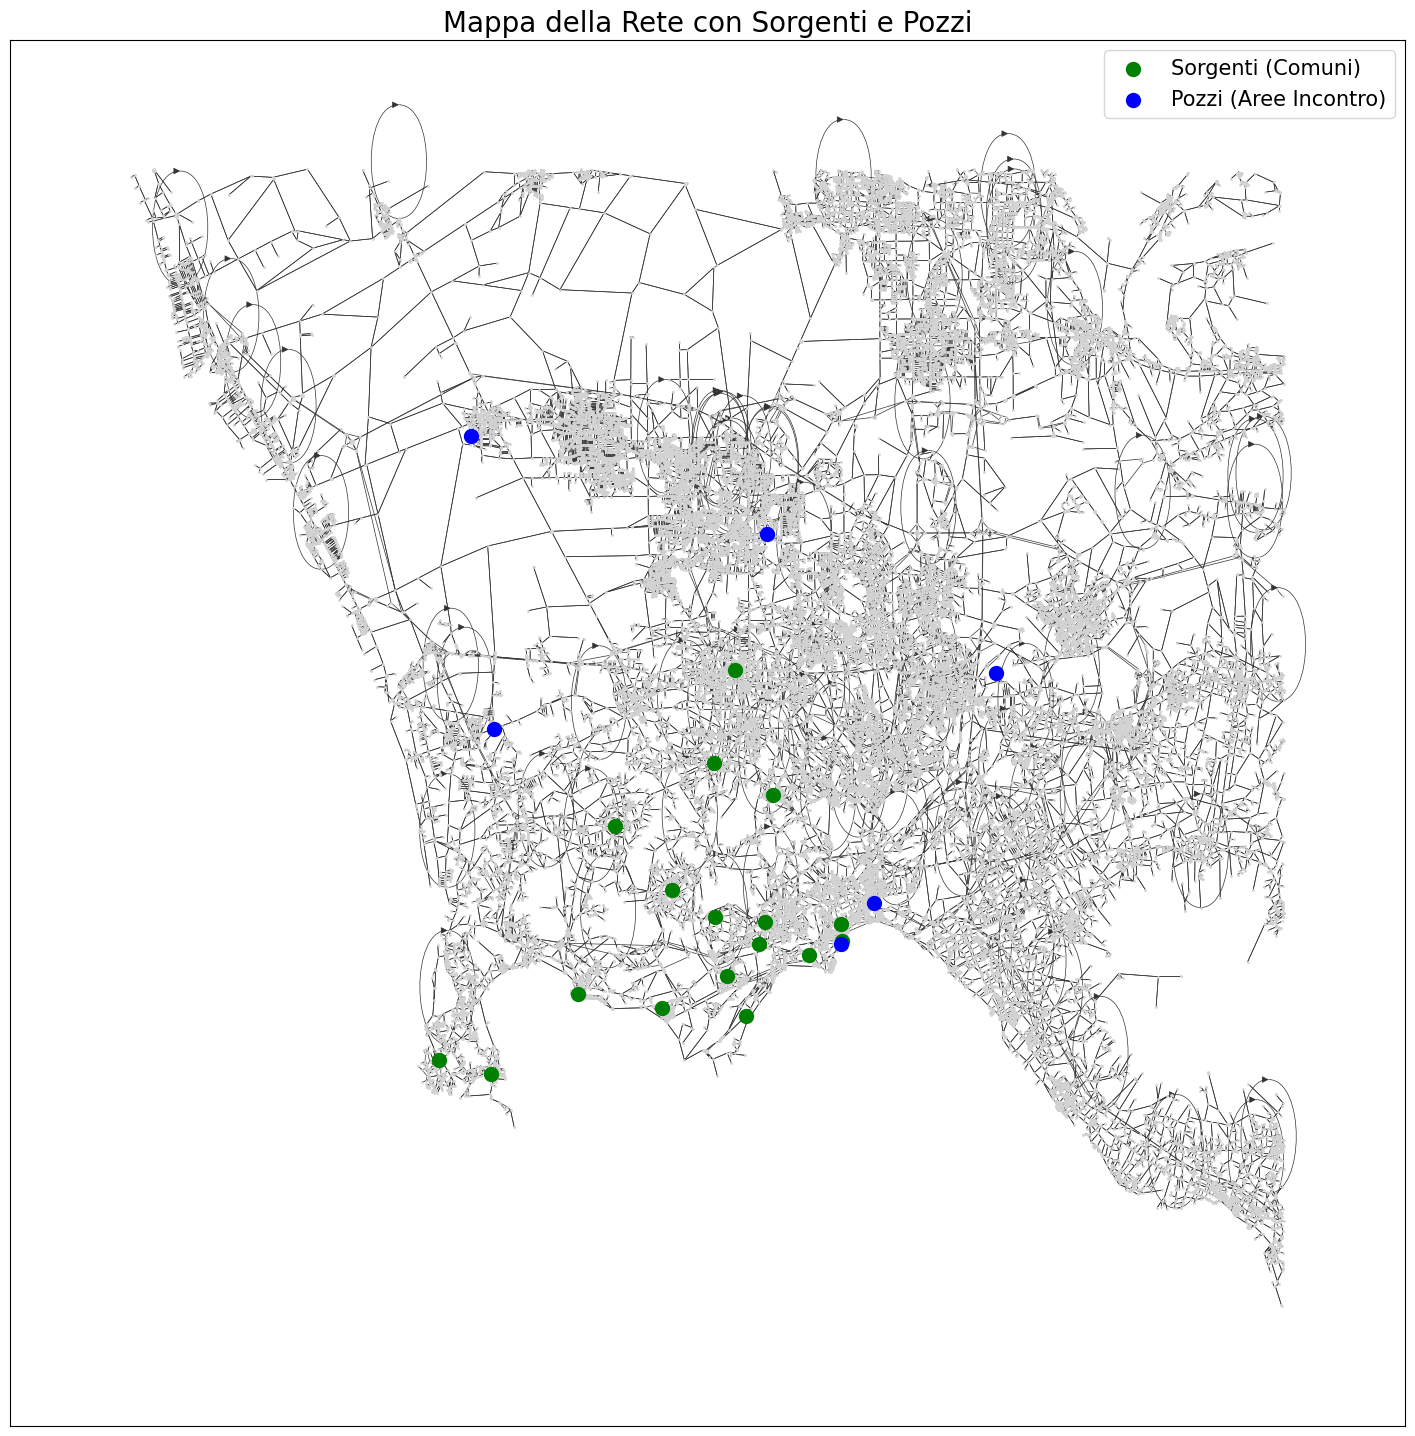

In [9]:
import matplotlib.pyplot as plt
print("\n--- Visualizzazione del Grafo con Sorgenti e Pozzi ---")

try:
    # Estrai le coordinate x, y di ogni nodo per il plottaggio
    posizioni = {node: (data['x'], data['y']) for node, data in G_simple.nodes(data=True) if 'x' in data and 'y' in data}

    fig, ax = plt.subplots(figsize=(18, 18))

    # 1. Disegna la rete stradale di base come sfondo (grigio chiaro)
    nx.draw_networkx_nodes(G_simple, posizioni, ax=ax, node_size=1, node_color='lightgray')
    nx.draw_networkx_edges(G_simple, posizioni, ax=ax, edge_color='#333333', width=0.5, arrows=False)

    # 2. Disegna i nodi SORGENTE in verde e più grandi
    #    list(sources_real.keys()) prende gli ID dei nodi delle sorgenti
    nx.draw_networkx_nodes(G_simple, posizioni, ax=ax,
                           nodelist=list(sources_real.keys()),
                           node_color='green',
                           node_size=100,
                           label='Sorgenti (Comuni)')

    # 3. Disegna i nodi POZZO in blu e più grandi
    #   list(sinks_real_nodes) prende gli ID dei nodi dei pozzi
    nx.draw_networkx_nodes(G_simple, posizioni, ax=ax,
                           nodelist=sinks_real_nodes,
                           node_color='blue',
                           node_size=100,
                           label='Pozzi (Aree Incontro)')

    ax.set_title("Mappa della Rete con Sorgenti e Pozzi", fontsize=20)
    ax.set_facecolor('white')
    ax.legend(prop={'size': 15}) # Legenda con dimensione del testo più grande

    print("Mostrando il grafico... Chiudi la finestra per continuare.")
    plt.show()

except Exception as e:
    print(f"\nATTENZIONE: Impossibile creare la visualizzazione completa. Errore: {e}")
